# Group Project: Pulsar Star Data 

### Introduction 

##### What are Pulsar Stars:

Pulsar stars are a very rare type of neutron star that produce radio emission detectable on Earth. As pulsar stars rotate rapidly and their emission beam sweeps across the sky, it produces a detectable pattern of repeating radio emission. Pulsar stars can be looked for through large radio telescopes.
 

##### Insight into Dataset: 

The HTRU2 dataset contains data about pulsars, both examples caused by RFI and/or noise, and real pulsar examples (noise is other radio signals also picked up thru pulsar star detection). The dataset contains a total of 17,898 samples of radio signals. This is an imbalanced dataset: 1,639 are real pulsar wave patterns while 16,259 are non-pulsar signals. Each pulsar star candidate is described by 8 continuous variables, and a single class variable. The first four columns are simple statistics obtained from the integrated pulse profile, an array of continuous variables that describe a longitude-resolved version of the signal that has been averaged in both time and frequency. The remaining four variables are similarly obtained from the DM-SNR curve, a Dispersion Measure - Signal- to-Noise Ratio curve that is obtained through the pulsar star signal. The 8 variables are as such:

1. Mean of the integrated profile.
2. Standard deviation of the integrated profile.
3. Excess kurtosis of the integrated profile.
4. Skewness of the integrated profile.
5. Mean of the DM-SNR curve.
6. Standard deviation of the DM-SNR curve.
7. Excess kurtosis of the DM-SNR curve.
8. Skewness of the DM-SNR curve.

Each row lists the variables first, and the class label is the final entry. The class labels used are 0 (negative) and 1 (positive).

##### Question:

Using the HTRU2 dataset, we aim to predict whether the candidate is a pulsar star or not. 



#### Method

- split data into training and testing data (with respect to the ratio of real and not real puslar stars)
- specify which variable we will use 
- standardize (scale center) all variables
- fold?
- find out which k is most optimal to use 
- build model with best k
- confusion matrix?

#### Expected Outcomes and Significance 

- expect to find - a model with high accuracy?
- could filter whether or not a certain signal is a pulsar or random radio noise?
- what makes a pulsar and radio noise different? 

In [120]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 10)

In [56]:
# all code comments are prompts to help with writing explanations/markdown comments

In [57]:
# briefly explain how setting the seed allows reproducibility

In [58]:
set.seed(77)

In [59]:
# Explain column name abbreviations (and meaning too? if word count allows)

In [60]:
# reading in data via unzip
# renaming columns since orig. data had no column names

# elaboration of unzipping the file:
# Create a temp. file name (eg tempfile())
# Use download.file() to fetch the file into the temp. file
# Use unz() to extract the target file from temp. file
# Remove the temp file via unlink()

# make sure you explicitly mention that the file is readable from the web

In [71]:
temp <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip",temp)
conn <- unz(temp, "HTRU_2.csv")
data <- read_csv(conn, col_names = FALSE)
unlink(temp)
data <- rename(data,
               mean = X1,
               st_dev = X2,
               e_kurtosis = X3,
               skewness = X4,
               snr_mean = X5,
               snr_st_dev = X6,
               snr_e_kurtosis = X7,
               snr_skewness = X8,
               status = X9) |>
    mutate(status = as_factor(status))
data

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mean,st_dev,e_kurtosis,skewness,snr_mean,snr_st_dev,snr_e_kurtosis,snr_skewness,status
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
136.4297,59.84742,-0.1878456,-0.73812297,1.296823,12.16606,15.450260,285.931022,0
122.5547,49.48561,0.1279781,0.32306090,16.409699,44.62689,2.945244,8.297092,0
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,0


In [72]:
# checking how many rows with missing values
# explain what we might do if there are any

In [73]:
missing_vals <- sum(is.na(data))
missing_vals

[1] 0

In [74]:
# there are no missing values therefore we dont need to take the steps we said we might have otherwise needed to

In [75]:
# split the data into training and testing
# explain why we do this (generic explanation)

In [76]:
data_split <- initial_split(data, prop = 0.75, strata = status)
data_train <- training(data_split)
data_test <- testing(data_split)

In [77]:
# describe what class bias means
# here we are counting the data points in each class to decide whether we need to correct for class bias

In [78]:
counts <- data_train |>
    group_by(status) |>
    summarize(n=n())

counts

status,n
<fct>,<int>
0,12205
1,1218


In [79]:
# There are many more non pulsars than pulsars
# we will upsample to correct for class bias

In [102]:
library(caret)
data_balanced <- upSample(x = data[, -ncol(data)] , y = data$status, yname = "status")
data_balanced
counts_balanced <- data_balanced |>
    group_by(status) |>
    summarize(n = n())

counts_balanced

mean,st_dev,e_kurtosis,skewness,snr_mean,snr_st_dev,snr_e_kurtosis,snr_skewness,status
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
92.95312,35.13764,1.286211,4.992276,8.152174,36.17958,4.67291532,21.754709,1
45.46094,31.83107,4.286203,24.408326,32.349498,70.76063,2.04204512,2.616415,1
50.71094,36.52678,3.057308,11.657628,80.775084,85.08107,0.51481162,-1.182962,1


status,n
<fct>,<int>
0,16259
1,16259


In [ ]:
#plotting unbalanced and balanced data to demonstrate oversampling


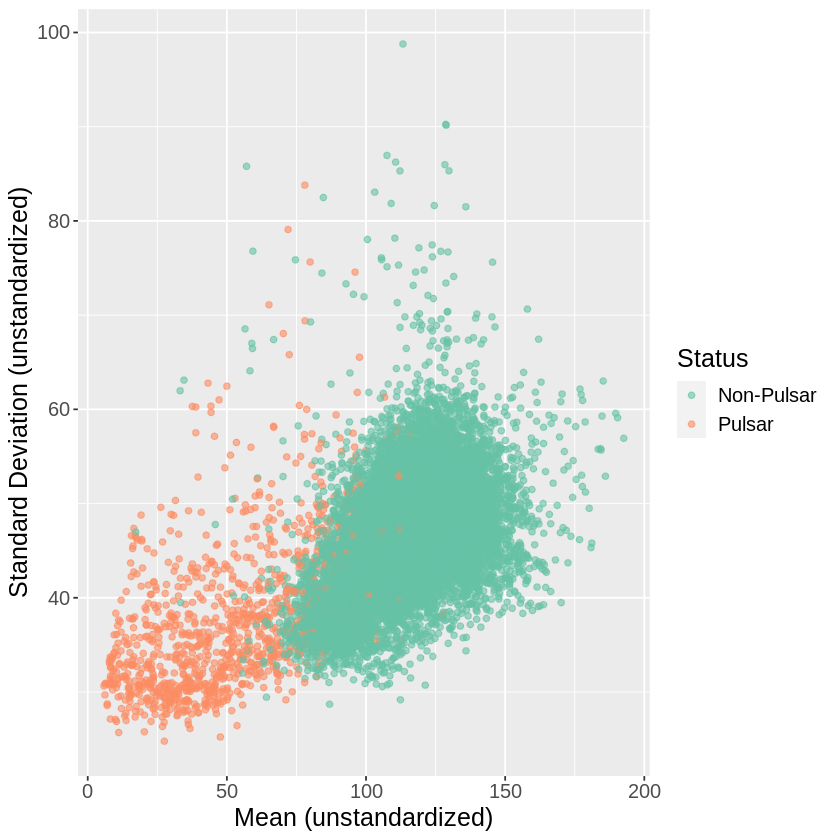

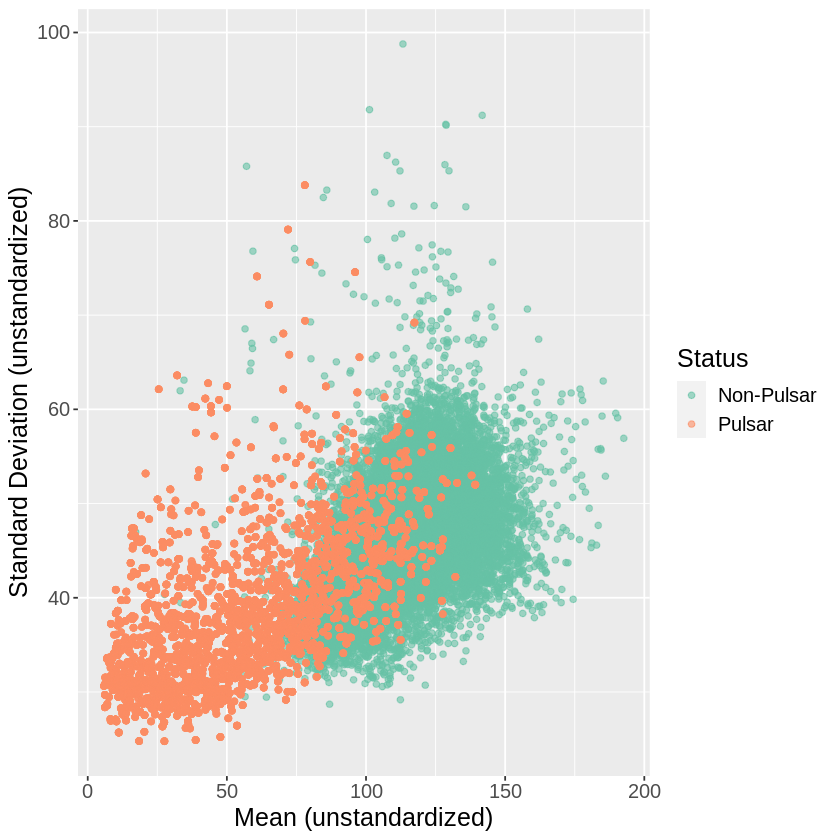

In [131]:
library(gridExtra)

par(mfcol=c(1,2))

mean_stdev_orig <- data_train |>
  ggplot(aes(x = mean, y = st_dev, color = status)) +
  geom_point(alpha = 0.6) +
  labs(x = "Mean (unstandardized)", 
       y = "Standard Deviation (unstandardized)",
       color = "Status") +
    scale_color_brewer(palette = "Set2", labels = c("Non-Pulsar", "Pulsar")) +
  theme(text = element_text(size = 15))

mean_stdev_bal <- data_balanced |>
  ggplot(aes(x = mean, y = st_dev, color = status)) +
  geom_point(alpha = 0.6) +
  labs(x = "Mean (unstandardized)", 
       y = "Standard Deviation (unstandardized)",
       color = "Status") +
    scale_color_brewer(palette = "Set2", labels = c("Non-Pulsar", "Pulsar")) +
  theme(text = element_text(size = 15))

mean_stdev_orig
mean_stdev_bal